In [ ]:
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/scribbless/another-anime-face-dataset")

# rezortchen
# 40c0d3580d79cba8d01f6cf6a009adb9

Skipping, found downloaded files in "./another-anime-face-dataset" (use force=True to force download)


In [ ]:
#od.download(
    #"https://www.kaggle.com/datasets/myzhang1029/chinese-landscape-painting-dataset")

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf


In [ ]:
path = "/content/another-anime-face-dataset/animefaces256cleaner/"

# https://www.kaggle.com/code/swepat/cyclegan-to-generate-monet-style-images

In [ ]:
def show_img_info(path):
    d_img_size = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_img_size[image.shape] = d_img_size.get(image.shape, 0)+1
    
    for size, count in d_img_size.items():
        print(f'shape: {size}\tcount: {count}')
        
show_img_info(path)

shape: (256, 256, 3)	count: 92219


In [ ]:
def imgToNp(path):
    data_np = np.empty((3000, 64, 64, 3), dtype = np.int64)
    idx = 0
    for image_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.resize(img, (64, 64))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = np.array(img)
        data_np[idx] = img_array
        idx+=1
        if idx >= 3000:break
        
    return data_np

In [ ]:
data = imgToNp(path)

In [ ]:
data.shape

(3000, 64, 64, 3)

In [ ]:
print(type(data))

<class 'numpy.ndarray'>


In [ ]:
print(data[1].shape)

(64, 64, 3)


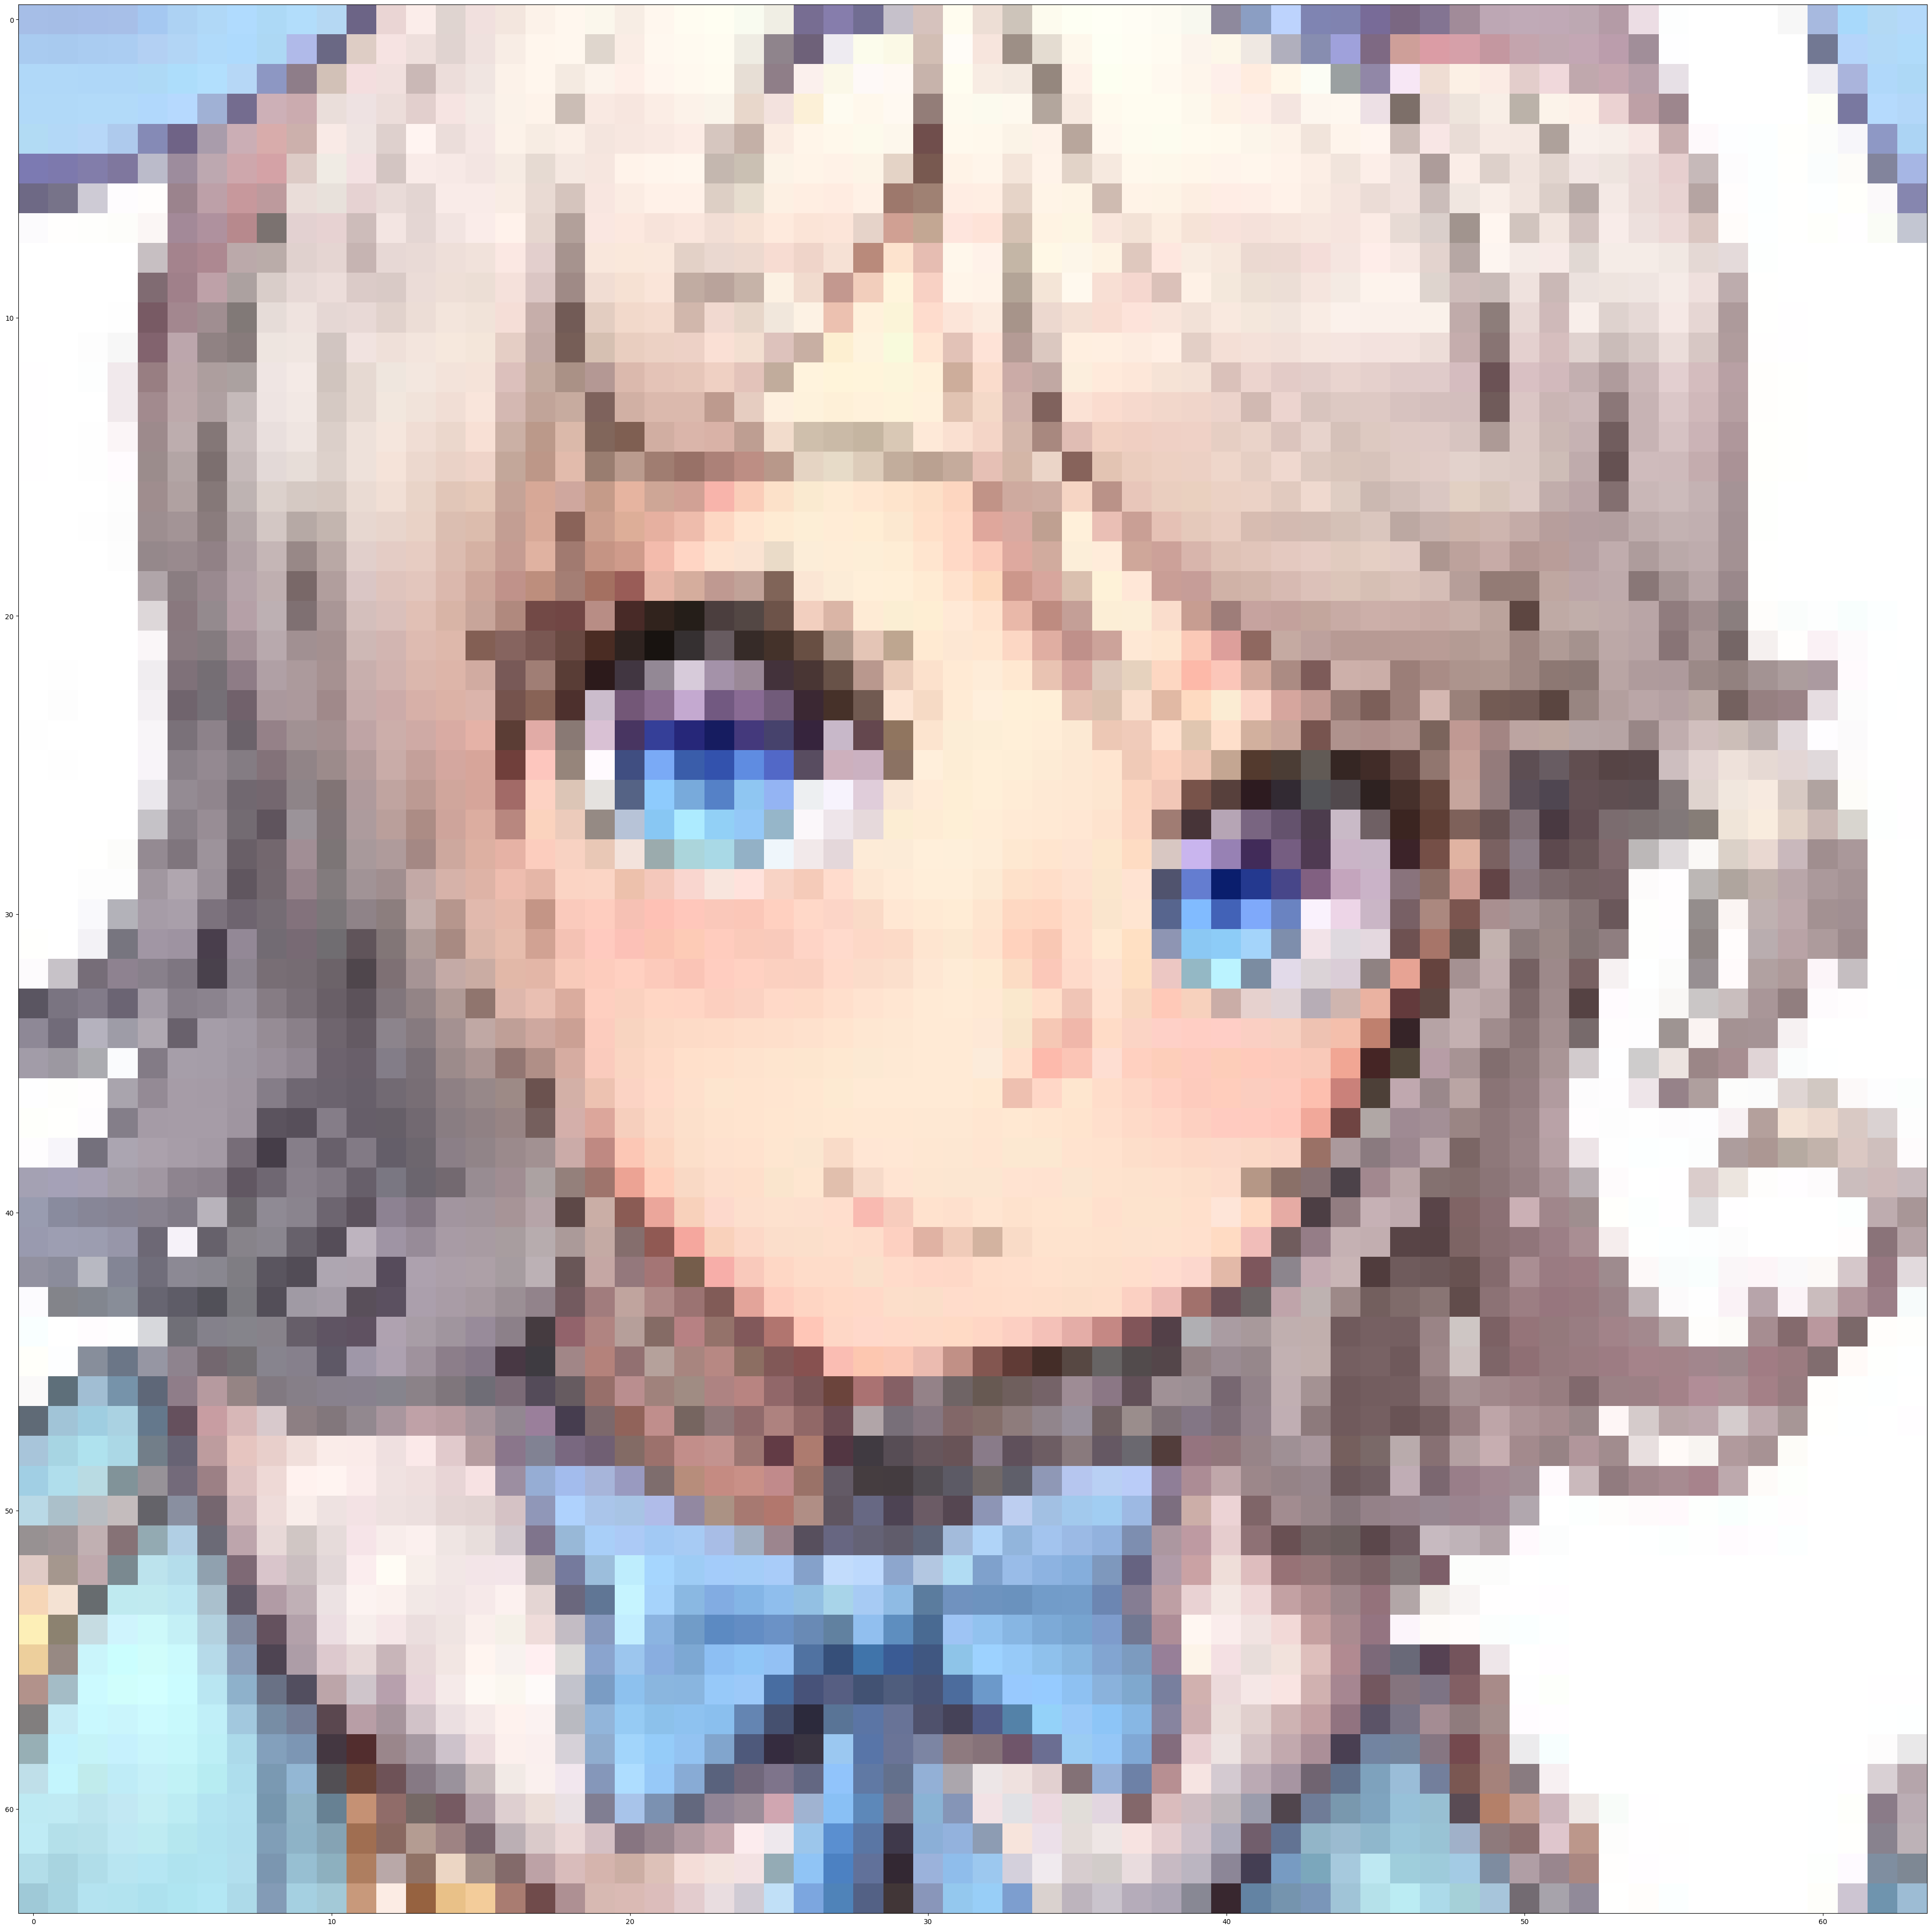

In [ ]:
image = data[2000]

plt.figure(figsize = (50, 50))
plt.imshow(image)
plt.show()

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Activation, LeakyReLU
from keras.optimizers import Adam
import numpy as np
import cv2
from keras.layers import UpSampling2D, Dropout, MaxPooling2D
import tensorflow as tf
from tensorflow import keras

In [ ]:
def build_generator():

    noise_shape = (100,)

    model = Sequential()

    # batchnormalization arg setting
    #m = 0.99
    e = 1e-5

    # noise to 4*4*3
    model.add(Dense(4 * 4 * 256, input_shape=noise_shape, activation = "linear"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    # upsample the img
    model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(LeakyReLU(alpha=0.2))
    # 8, 8, 512
    model.add(BatchNormalization(epsilon = e))

    model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(LeakyReLU(alpha=0.2))
    # 16, 16, 256
    model.add(BatchNormalization(epsilon = e))

    model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(LeakyReLU(alpha=0.2))
    # 32, 32, 128
    model.add(BatchNormalization(epsilon = e))

    model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(LeakyReLU(alpha=0.2))
    # 64, 64, 64
    model.add(BatchNormalization(epsilon = e))

    # 输出128x128x3的图像
    model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    
    model.summary()


    noise = Input(shape=noise_shape)
    img = model(noise)

 
    generator_model = Model(inputs=noise, outputs=img)

    return generator_model

In [ ]:
generator = build_generator()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 8, 8, 512)        2097664   
 Transpose)                                                      
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 8, 8, 512)         0         
                                                                 
 batch_normalization_60 (Bat  (None, 8, 8, 512)        2048      
 chNormalization)                                    

In [ ]:
def build_discriminator():

    img_shape = (64, 64, 3)

    model = Sequential()


    model.add(Conv2D(128, kernel_size=3, strides=1, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))


    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    
    img = Input(shape=img_shape)
    validity = model(img)

    
    discriminator_model = Model(inputs=img, outputs=validity)

    return discriminator_model

In [ ]:
discriminator = build_discriminator()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_83 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_64 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_65 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                    

In [ ]:
class gan():
  def __init__(self, generator, discriminator):
    self.generator = generator
    self.discriminator = discriminator
    self.optimizer = Adam(0.0002, 0.5)
    #self.data = data

    self.generator.compile(optimizer = self.optimizer, loss = "binary_crossentropy")
    self.discriminator.compile(optimizer = self.optimizer, loss = "binary_crossentropy", metrics = ['accuracy'])

    self.discriminator.trainable = False
    gan_input = Input(shape=(100,))
    generated_img = self.generator(gan_input)
    validity = self.discriminator(generated_img)
    self.gan = Model(inputs=gan_input, outputs=validity)
    self.gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)
  
  def train(self, X_train, epochs, batch_size):

    # transfrom data
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    optimizer = Adam(0.00002, 0.5)
    
    #generated_imgss = []


    for epoch in range(epochs):

        # choose real imgs
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # generate noise and fake imgs
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_imgs = self.generator.predict(noise)

        # training discriminator
        d_loss_real = self.discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_generated = self.discriminator.train_on_batch(generated_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_generated)
        


        # training generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = self.gan.train_on_batch(noise, np.ones((batch_size, 1)))
        g_loss = self.gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # print gan loss condition
        if epoch%20 == 0:
          print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # save imgs
        if epoch % 200 == 0:
          self.safe_img()

        if epoch%1500 == 0:
          self.generator.save("generator_%d" % epoch)
          self.discriminator.save("discriminator_%d" % epoch)
     
    return 0

  def safe_img(self):
    noise = np.random.normal(0, 1, (1,100))
    img = self.generator.predict(noise)
    img = (img+1)*127.5
    img = img.astype(np.int64)
    #img = 0.5 * img + 0.5
    plt.figure(figsize = (8,8))
    plt.imshow(img[0])
    plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!mkdir animeGenerated

mkdir: cannot create directory ‘animeGenerated’: File exists


4/4 [==============================] - 0s 27ms/step
0 [Discriminator loss: 1.207339, acc.: 24.61%] [Generator loss: 0.703562]
1/1 [==============================] - 0s 181ms/step


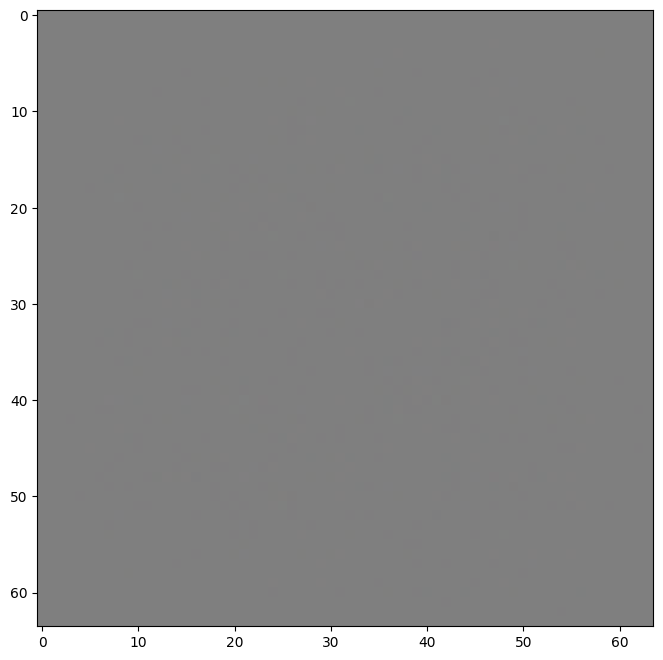

4/4 [==============================] - 0s 13ms/step
20 [Discriminator loss: 0.014475, acc.: 100.00%] [Generator loss: 0.254731]
4/4 [==============================] - 0s 13ms/step
40 [Discriminator loss: 0.003234, acc.: 100.00%] [Generator loss: 0.022014]
4/4 [==============================] - 0s 13ms/step
60 [Discriminator loss: 0.001411, acc.: 100.00%] [Generator loss: 0.001190]
4/4 [==============================] - 0s 13ms/step
80 [Discriminator loss: 0.000622, acc.: 100.00%] [Generator loss: 0.000076]
4/4 [==============================] - 0s 14ms/step
100 [Discriminator loss: 0.000519, acc.: 100.00%] [Generator loss: 0.000004]
4/4 [==============================] - 0s 13ms/step
120 [Discriminator loss: 0.000839, acc.: 100.00%] [Generator loss: 0.000002]
4/4 [==============================] - 0s 13ms/step
140 [Discriminator loss: 0.000534, acc.: 100.00%] [Generator loss: 0.000004]
4/4 [==============================] - 0s 14ms/step
160 [Discriminator loss: 0.000537, acc.: 100.00%]

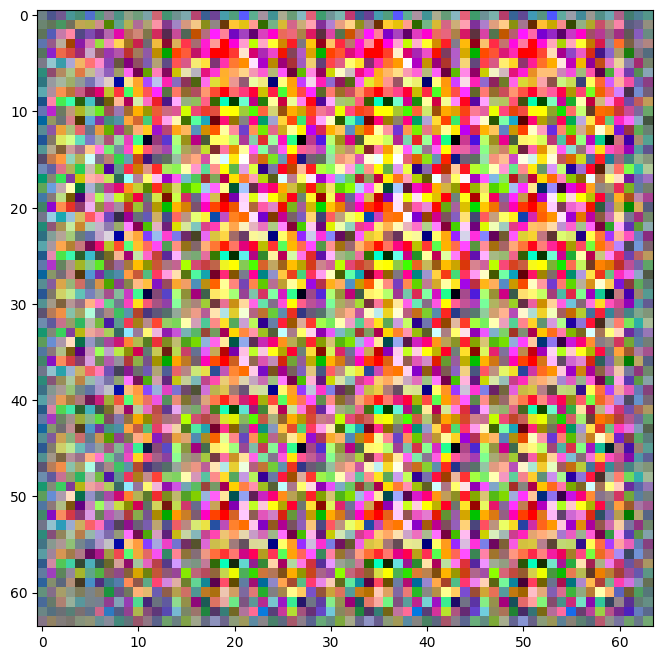

4/4 [==============================] - 0s 13ms/step
220 [Discriminator loss: 0.002869, acc.: 100.00%] [Generator loss: 0.002618]
4/4 [==============================] - 0s 13ms/step
240 [Discriminator loss: 0.002813, acc.: 100.00%] [Generator loss: 0.001583]
4/4 [==============================] - 0s 13ms/step
260 [Discriminator loss: 0.002006, acc.: 100.00%] [Generator loss: 0.001278]
4/4 [==============================] - 0s 14ms/step
280 [Discriminator loss: 0.001362, acc.: 100.00%] [Generator loss: 0.001148]
4/4 [==============================] - 0s 13ms/step
300 [Discriminator loss: 0.001142, acc.: 100.00%] [Generator loss: 0.000993]
4/4 [==============================] - 0s 13ms/step
320 [Discriminator loss: 0.000632, acc.: 100.00%] [Generator loss: 0.000975]
4/4 [==============================] - 0s 13ms/step
340 [Discriminator loss: 0.000682, acc.: 100.00%] [Generator loss: 0.000906]
4/4 [==============================] - 0s 13ms/step
360 [Discriminator loss: 0.000545, acc.: 100.

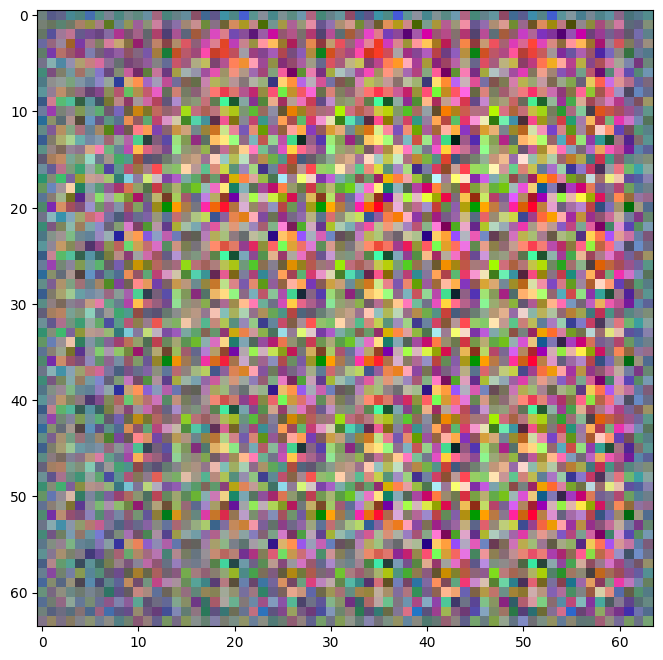

4/4 [==============================] - 0s 14ms/step
420 [Discriminator loss: 0.000477, acc.: 100.00%] [Generator loss: 0.000706]
4/4 [==============================] - 0s 14ms/step
440 [Discriminator loss: 0.000347, acc.: 100.00%] [Generator loss: 0.000762]
4/4 [==============================] - 0s 13ms/step
460 [Discriminator loss: 0.000315, acc.: 100.00%] [Generator loss: 0.000612]
4/4 [==============================] - 0s 13ms/step
480 [Discriminator loss: 0.000315, acc.: 100.00%] [Generator loss: 0.000606]
4/4 [==============================] - 0s 14ms/step
500 [Discriminator loss: 0.000257, acc.: 100.00%] [Generator loss: 0.000577]
4/4 [==============================] - 0s 15ms/step
520 [Discriminator loss: 0.000215, acc.: 100.00%] [Generator loss: 0.000518]
4/4 [==============================] - 0s 13ms/step
540 [Discriminator loss: 0.000312, acc.: 100.00%] [Generator loss: 0.000438]
4/4 [==============================] - 0s 13ms/step
560 [Discriminator loss: 0.000199, acc.: 100.

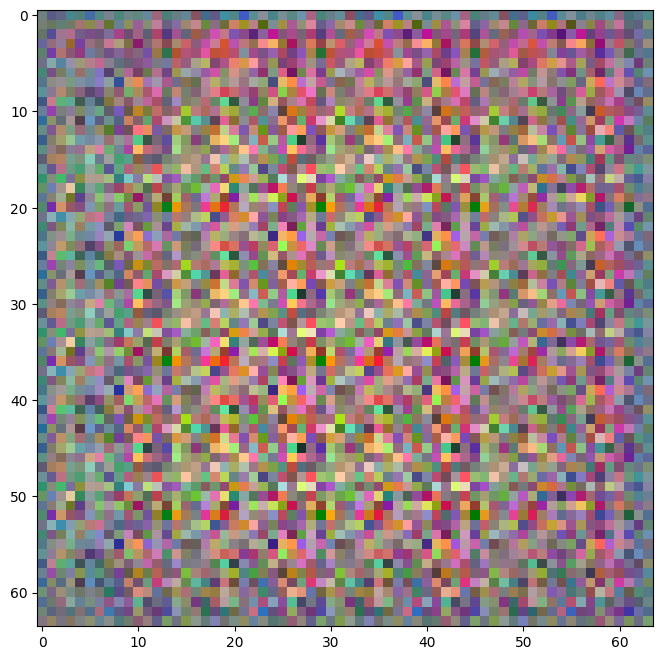

4/4 [==============================] - 0s 13ms/step
620 [Discriminator loss: 0.000204, acc.: 100.00%] [Generator loss: 0.000402]
4/4 [==============================] - 0s 13ms/step
640 [Discriminator loss: 0.000116, acc.: 100.00%] [Generator loss: 0.000359]
4/4 [==============================] - 0s 13ms/step
660 [Discriminator loss: 0.000114, acc.: 100.00%] [Generator loss: 0.000335]
4/4 [==============================] - 0s 14ms/step
680 [Discriminator loss: 0.000161, acc.: 100.00%] [Generator loss: 0.000323]
4/4 [==============================] - 0s 13ms/step
700 [Discriminator loss: 0.000104, acc.: 100.00%] [Generator loss: 0.000328]
4/4 [==============================] - 0s 14ms/step
720 [Discriminator loss: 0.000149, acc.: 100.00%] [Generator loss: 0.000273]
4/4 [==============================] - 0s 14ms/step
740 [Discriminator loss: 0.000107, acc.: 100.00%] [Generator loss: 0.000263]
4/4 [==============================] - 0s 13ms/step
760 [Discriminator loss: 0.000118, acc.: 100.

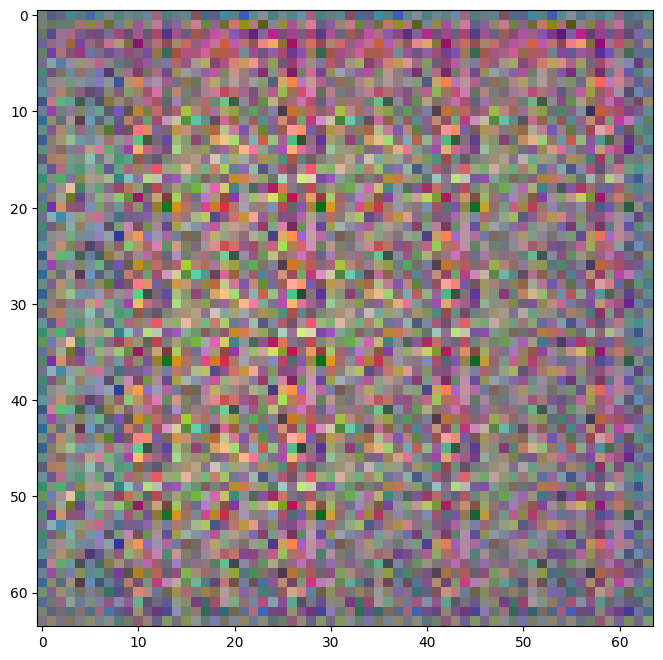

4/4 [==============================] - 0s 15ms/step
820 [Discriminator loss: 0.000084, acc.: 100.00%] [Generator loss: 0.000249]
4/4 [==============================] - 0s 13ms/step
840 [Discriminator loss: 0.000081, acc.: 100.00%] [Generator loss: 0.000210]
4/4 [==============================] - 0s 13ms/step
860 [Discriminator loss: 0.000093, acc.: 100.00%] [Generator loss: 0.000259]
4/4 [==============================] - 0s 13ms/step
880 [Discriminator loss: 0.000077, acc.: 100.00%] [Generator loss: 0.000225]
4/4 [==============================] - 0s 14ms/step
900 [Discriminator loss: 0.000069, acc.: 100.00%] [Generator loss: 0.000246]
4/4 [==============================] - 0s 14ms/step
920 [Discriminator loss: 0.000086, acc.: 100.00%] [Generator loss: 0.000203]
4/4 [==============================] - 0s 13ms/step
940 [Discriminator loss: 0.000072, acc.: 100.00%] [Generator loss: 0.000219]
4/4 [==============================] - 0s 13ms/step
960 [Discriminator loss: 0.000069, acc.: 100.

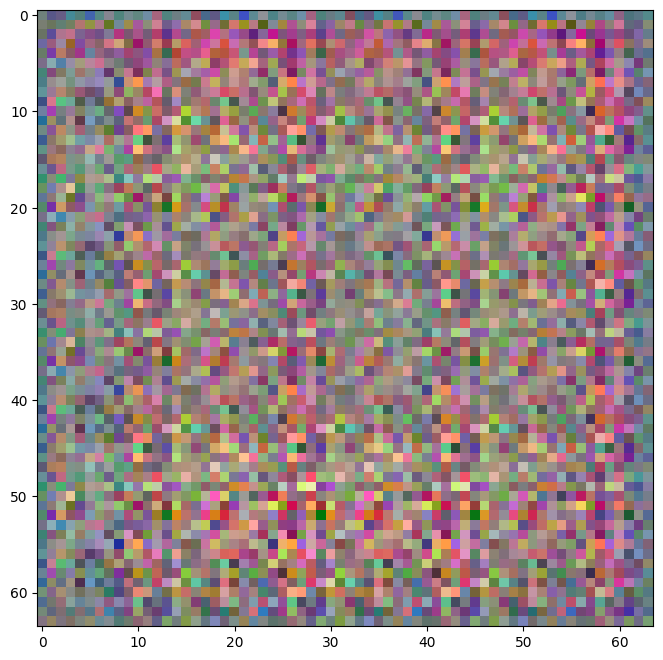

4/4 [==============================] - 0s 13ms/step
1020 [Discriminator loss: 0.000082, acc.: 100.00%] [Generator loss: 0.000188]
4/4 [==============================] - 0s 13ms/step


In [ ]:
GAN = gan(generator, discriminator)
GAN.train(data, 10000, 128)


In [ ]:


def build_gan(generator, discriminator):

    # 将判别器的权重设置为不可训练
    discriminator.trainable = False

    # 定义GAN模型，输入噪声并通过生成器生成图像，然后输入判别器进行分类
    gan_input = Input(shape=(100,))
    generated_img = generator(gan_input)
    validity = discriminator(generated_img)

    # 构建GAN模型
    gan = Model(inputs=gan_input, outputs=validity)

    # 设置优化器和损失函数
    optimizer = Adam(learning_rate=0.00002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    return gan
gan = build_gan(generator, discriminator)

In [ ]:
def safe_img(generator):
  noise = np.random.normal(0, 1, (25,100))
  img = generator.predict(noise)
  img = (img+1)*127.5
  img = img.astype(np.int64)
  #img = 0.5 * img + 0.5
  fig, axs = plt.subplots(5,5, figsize = (8,8))
  idx = 0
  for i in range(5):
    for j in range(5):
      axs[i,j].imshow(img[5*i+j])
      axs[i,j].axis('off')
  plt.show()
  fig.savefig("animeGenerated/Faces_%d.png" % idx)
  plt.close()
  idx+=1
  #return img

1/1 [==============================] - 2s 2s/step


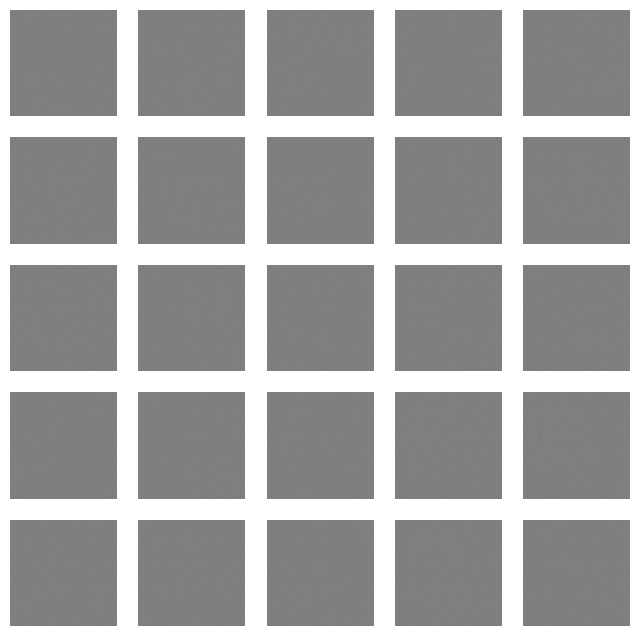

In [ ]:
safe_img(generator)

In [ ]:
def train(generator, discriminator, gan, X_train, epochs, batch_size):

    # 将图像数据缩放到[-1, 1]之间
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    optimizer = Adam(0.00002, 0.5)
    # 创建一个保存生成图像的列表，用于展示训练进度
    generated_imgss = []
    #generated_imgs = list(generated_imgs)
    #print(type)

    #history_D = []
    #history_G = []

    for epoch in range(epochs):

        # 随机选择一批真实图像
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # 生成一批噪声向量，并通过生成器生成图像
        noise = np.random.normal(0, 1, (batch_size, 100))
        #noise = np.random.uniform(-1, 1, (batch_size, 200))
        generated_imgs = generator.predict(noise)

        # 训练判别器，让其能够正确地区分真实图像和生成图像
        discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_generated = discriminator.train_on_batch(generated_imgs, np.zeros((batch_size, 1)))
        D_LOSS = d_loss_real
        d_loss = 0.5 * np.add(d_loss_real, d_loss_generated)
        


        # 训练生成器，让其生成能够欺骗判别器的图像
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # 打印损失和训练进度
        #print("Epoch %d/%d [D loss: %f] [G loss: %f]" % (epoch+1, epochs, d_loss, g_loss))
        if epoch%20 == 0:
          #print("Epoch: " , epoch+1,"/", epochs, " D loss: ", d_loss, " G loss: ", g_loss)
          print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        #history_D.append(D_LOSS)
        #history_G.append(g_loss)
        # 保存生成的图像
        if epoch % 200 == 0:
          safe_img(generator)
          #generated_imgss.append(generated_imgs)
        
    return 0
    # 返回生成的图像列表
    #return generated_imgs #,history_D, history_G

4/4 [==============================] - 2s 77ms/step
0 [Discriminator loss: 0.717471, acc.: 51.56%] [Generator loss: 0.902944]
1/1 [==============================] - 0s 55ms/step


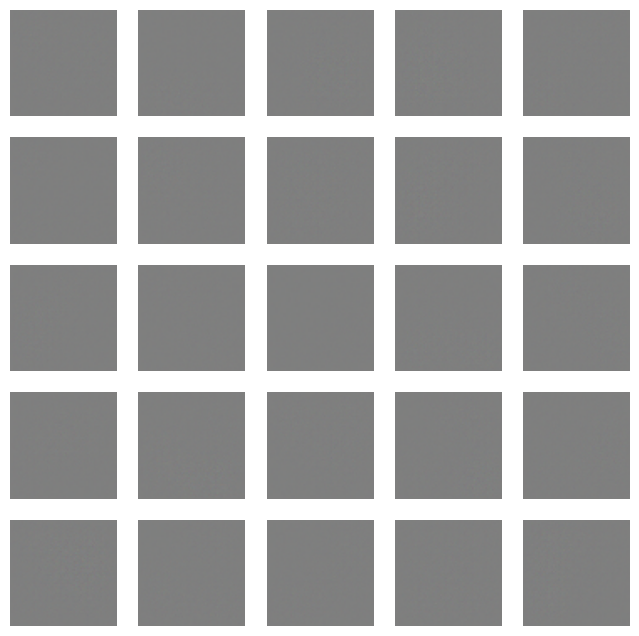

4/4 [==============================] - 0s 111ms/step
20 [Discriminator loss: 0.717382, acc.: 51.56%] [Generator loss: 0.858056]
4/4 [==============================] - 0s 113ms/step
40 [Discriminator loss: 0.713756, acc.: 52.73%] [Generator loss: 0.845536]
4/4 [==============================] - 0s 114ms/step


KeyboardInterrupt: ignored

In [ ]:
imgs, historyd, historyg = train(generator, discriminator, gan, data, 10000, 128)